# Задание

- Наша команда приняла решение работать с размеченными данными для японского языка, пока корпус полисинтетического языка мапудунгун находится в стадии разметки.

- Мы скачали корпус с сайта Universal Dependencies, он представлен в виде трёх файлов (обучающая, валидационная и тестовая выборки) в папке __data__.

- Цель: а) написать функцию для чтения этих данных, чтобы потом их можно было подавать на вход модели; б) исследовать данные.

## Устройство корпуса

- Корпус записан в формате CoNLL-U
- Первая строка в предложении выглядит так: _# sent_id = train-s1_. Мы не извлекаем из неё никакой информации.
- Далее идёт строка вида: _# text = ホッケーにはデンジャラスプレーの反則があるので、膝より上にボールを浮かすことは基本的に反則になるが、その例外の一つがこのスクープである。_ Опять же, пропускаем.
- Наконец, следующие строки будут соответствовать каждая своему токену (вспомните разметку для NER из курса компьютерной лингвистики, только колонок намного больше двух).
- Вот пример строки токена: _2	に	に	ADP	PS	_	1	case	_	SpaceAfter=No_
- Первая колонка: номер токена в предложении (__нумерация начинается с 1__).
- Вторая колонка: сам токен, как он выглядит в предложении.
- Третья колонка: лемма.
- Четвёртая колонка: часть речи (UPOS, Universal POS-tags).
- Пятая колонка: XPOS (language-specific POS-tags).
- Шестая колонка: другие грамматические теги.
- Седьмая колонка: индекс токена, который является вершиной для текущего токена.
- Восьмая колонка: тип отношения между токеном и его вершиной.
- Девятая колонка: ???
- Десятая колонка: есть ли в предложении после этого токена пробел (всегда значение "нет").
- Предложения разделены пустыми строками (символами __\n__).

## Задача №1

Напишите функцию для чтения корпуса в таком формате со следующей сигнатурой:
- вход: путь до файла
- выход: список список кортежей (__List[List[Tuple]]__), где в верхнем списке лежат предложения, во вложенном списке — токены, а каждый токен представлен как кортеж длины 10, где каждое значение соответствует своей колонке

Перед тем как вернуть полученный список списков кортежей, убедитесь с помощью оператора __assert__, что:
- длина всех кортежей равна 10;
- длина каждого вложенного списка больше или равна единице.

Кроме того, проверьте, что при чтении файлов не возникает проблем с кодировкой.

In [1]:
import os
import re
from typing import List, Tuple
from collections import Counter

import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline
sns.set_style('whitegrid')

In [2]:
def read_corpus(filepath: str) -> List[List[Tuple[str]]]:
    output = []
    
    with open(filepath, 'r') as f:
        for sentence in re.split(r'\n\n+', f.read()):
            if not sentence:
                continue
            
            output.append([])
            for token in sentence.split('\n'):
                if token.startswith('#') or not token:
                    continue
                    
                output[-1].append(tuple(token.split('\t')))
    
    assert all(len(token) == 10 for sentence in output for token in sentence)
    assert all(len(sentence) > 0 for sentence in output)
    
    return output

In [3]:
corpus = []

for filename in os.listdir('data'):
    print(filename)
    corpus.extend(read_corpus('data/' + filename))

ja_gsd-ud-train.conllu
ja_gsd-ud-test.conllu
ja_gsd-ud-dev.conllu


## Задача №2

- Посчитайте, сколько в корпусе есть размеченных предложений и токенов.

In [4]:
len(corpus)

8186

In [5]:
num_tokens = sum(len(sentence) for sentence in corpus)
num_tokens

184072

- Количество уникальных символов

In [6]:
num_chars = len(set([char for sentence in corpus for token in sentence for char in token[1]]))
num_chars

2916

- Посчитайте, в каком проценте случаев лемма совпадает с токеном.

In [7]:
count = 0

for sentence in corpus:
    for token in sentence:
        if token[1] == token[2]:
            count += 1
print(f'В {count / num_tokens * 100:.2f}% случаев лемма совпадает с токеном.')

В 87.42% случаев лемма совпадает с токеном.


- Для четвёртой, пятой, восьмой, девятой и десятой колонки составьте списки встречаемых значений и посчитайте их частотность.
- Проделайте аналогичную работу для шестой колонки, но в процессе также разбивайте её по символу |. Посчитайте частотность каждого отдельного тега.

In [8]:
sentence_lengths, token_lengths, upos, xpos, tags, rel_types, col_9, space_after = [], [], [], [], [], [], [], []

In [9]:
for sentence in corpus:
    sentence_lengths.append(len(sentence))
    for token in sentence:
        token_lengths.append(len(token[1]))
        upos.append(token[3])
        xpos.append(token[4])
        tags.extend(token[5].split('|'))
        rel_types.append(token[7])
        col_9.append(token[8])
        space_after.append(token[9])

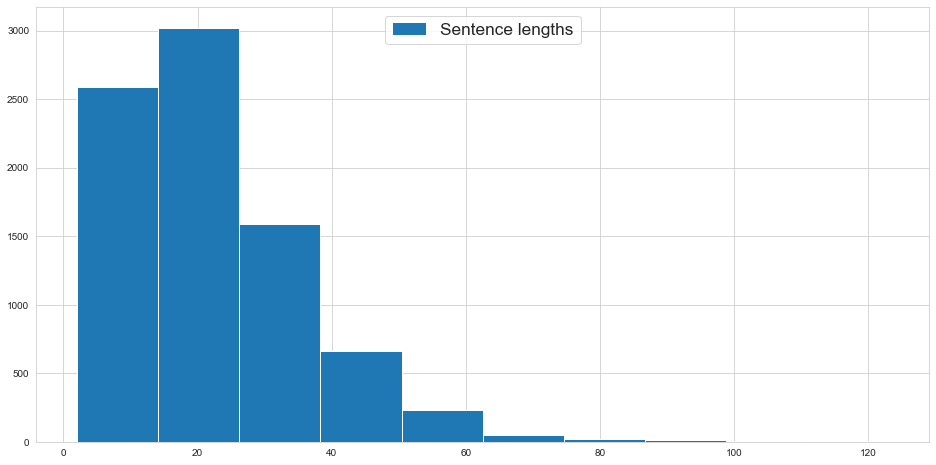

In [10]:
plt.figure(figsize=(16, 8))
plt.hist(sentence_lengths)
plt.legend(['Sentence lengths'], loc='upper center', fontsize='xx-large')
plt.show()

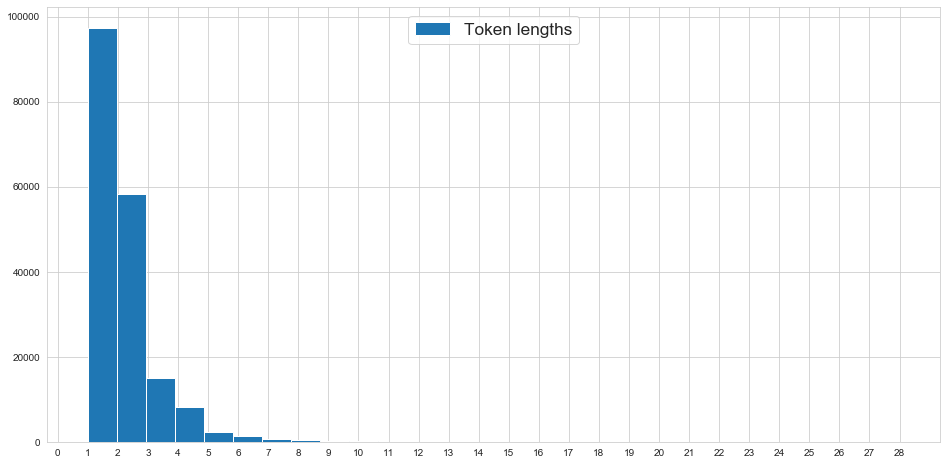

In [11]:
plt.figure(figsize=(16, 8))
plt.hist(token_lengths, bins=max(token_lengths))
plt.xticks(list(range(max(token_lengths) + 1)))
plt.legend(['Token lengths'], loc='upper center', fontsize='xx-large')
plt.show()

In [15]:
upos_counts = Counter(upos)

[upos for upos, count in upos_counts.items() if count < 300]

['INTJ']

Мало примеров только для тега INTJ.
Возможно, для этой части речи стоит написать какие-нибудь костыли.

In [16]:
', '.join(sorted(set(upos), key=lambda x: upos_counts[x], reverse=True))

'NOUN, ADP, AUX, PUNCT, VERB, PROPN, SCONJ, ADJ, NUM, ADV, SYM, PRON, PART, CCONJ, DET, INTJ'

In [18]:
xpos_counts = Counter(xpos)

[xpos for xpos, count in xpos_counts.items() if count < 300]

['PP', 'XA', 'PF', 'AJ', 'PX', 'UH', 'UNK', 'AJN']

Для кучи тегов здесь мало примеров.

In [19]:
', '.join(sorted(set(xpos), key=lambda x: xpos_counts[x], reverse=True))

'NN, PS, SYM, VV, AV, NNP, PN, PK, PC, XV, CD, XS, XSC, JN, NR, RB, PQ, NB, JJ, PNB, JR, PA, XP, NP, CC, PH, PM, XPC, PE, PP, XA, PF, AJ, PX, UNK, UH, AJN'

In [14]:
Counter(tags)

Counter({'_': 179726, 'NumType=Card': 4346})

Здесь всё хорошо.

In [21]:
rel_counts = Counter(rel_types)

[rel for rel, count in rel_counts.items() if count < 300]

['dislocated', 'discourse', 'dep']

Три редких типа отношений.

In [22]:
', '.join(sorted(set(rel_types), key=lambda x: rel_counts[x], reverse=True))

'case, aux, punct, compound, nmod, obl, mark, advcl, root, nsubj, acl, obj, iobj, nummod, advmod, cop, det, amod, cc, csubj, ccomp, fixed, dislocated, discourse, dep'

In [16]:
Counter(col_9)

Counter({'_': 184072})

In [17]:
Counter(space_after)

Counter({'SpaceAfter=No': 183425, '_': 647})

Это две мусорные колонки.

- Проверьте, есть ли корреляция между частью речи токена-вершины и типом отношения. Не забывайте, что в UD нумерация начинается с единицы, а в Python — с нуля!

In [18]:
from collections import defaultdict, Counter

rel2pos = defaultdict(list)

for sentence in corpus:
    for token in sentence:
        if token[7] == 'root':
            continue
            
        rel2pos[token[7]].append(sentence[int(token[6]) - 1][3])

In [19]:
for key, value in rel2pos.items():
    counts = Counter(value)
    max_count = max(counts.items(), key = lambda x: x[1])
    if max_count[1] / sum(counts.values()) >= 0.9:
        print(f'{key}: {max_count[0]}')

iobj: VERB
obj: VERB
det: NOUN
nummod: NOUN
acl: NOUN
amod: NOUN
ccomp: VERB
dep: VERB
